![Py4Eng](../logo.png)

# Autoencoders
## Yoav Ram

An autoencoder is a model that encodes an image to its features, and then decoded the features back to the (original) image. This is useful for a variety of applications, such as lossy compression, data generation, and unsupervised feature learning.

![autoencoder](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

We will create a simple autoencoder using FFN, but more examples are [available](https://blog.keras.io/building-autoencoders-in-keras.html).



In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax.numpy as np
import seaborn as sns
import pickle

import jax
import keras
print('Keras:', keras.__version__, 'backend:', keras.backend.backend(), jax.default_backend())

Keras: 3.7.0 backend: jax cpu


In [2]:
def display_image(im):
    fig, ax = plt.subplots()
    ax.imshow(im, cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])    

We first load the MNIST dataset.

In [3]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
nsamples, width, height = X_train.shape
X_train = (X_train/255).astype('float32')
X_test = (X_test/255).astype('float32')

In [4]:
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

We start with the **encoder**, which encodes a 28x28 image to a features vector of length 32.

In [6]:
# this is the size of our encoded representations
# compression of factor 24.5
nfeatures = 32  

encoder = keras.Sequential([
    keras.layers.Input((width, height)),
    keras.layers.Flatten(),
    keras.layers.Dense(nfeatures, activation='tanh')
])

The **decoder** decoded the features vector back to an image.

In [7]:
decoder = keras.Sequential([
    keras.layers.Input((nfeatures,)),
    keras.layers.Dense(width * height, activation='sigmoid'),
    keras.layers.Reshape(target_shape=(width, height))
])  

Now the **autoencoder** encodes an image and decoed it back using the encoder and decoder. This is where we apply the functional API.

In [8]:
input_image = keras.Input((width, height))
encoded = encoder(input_image)
decoded = decoder(encoded)

autoencoder = keras.Model(input_image, decoded)
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28)         │        25,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

We compile the autoencoder so we can train it on reconstructing images.

In [9]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Now we train the autoencoder.

In [10]:
history = autoencoder.fit(X_train, X_train, # Y=X
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test)).history

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.4363 - val_loss: 0.2710
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2692 - val_loss: 0.2653
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2650 - val_loss: 0.2639
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2638 - val_loss: 0.2633
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2631 - val_loss: 0.2579
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2558 - val_loss: 0.2519
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2514 - val_loss: 0.2488
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2486 - val_loss: 0.2436
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2420 - val_loss: 0.2366
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2362 - val_loss: 0.2335
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2342 - val_loss: 0.2318
Epoch 12/100
235/235 ━━━━━━━━━━━━━━━━━━━

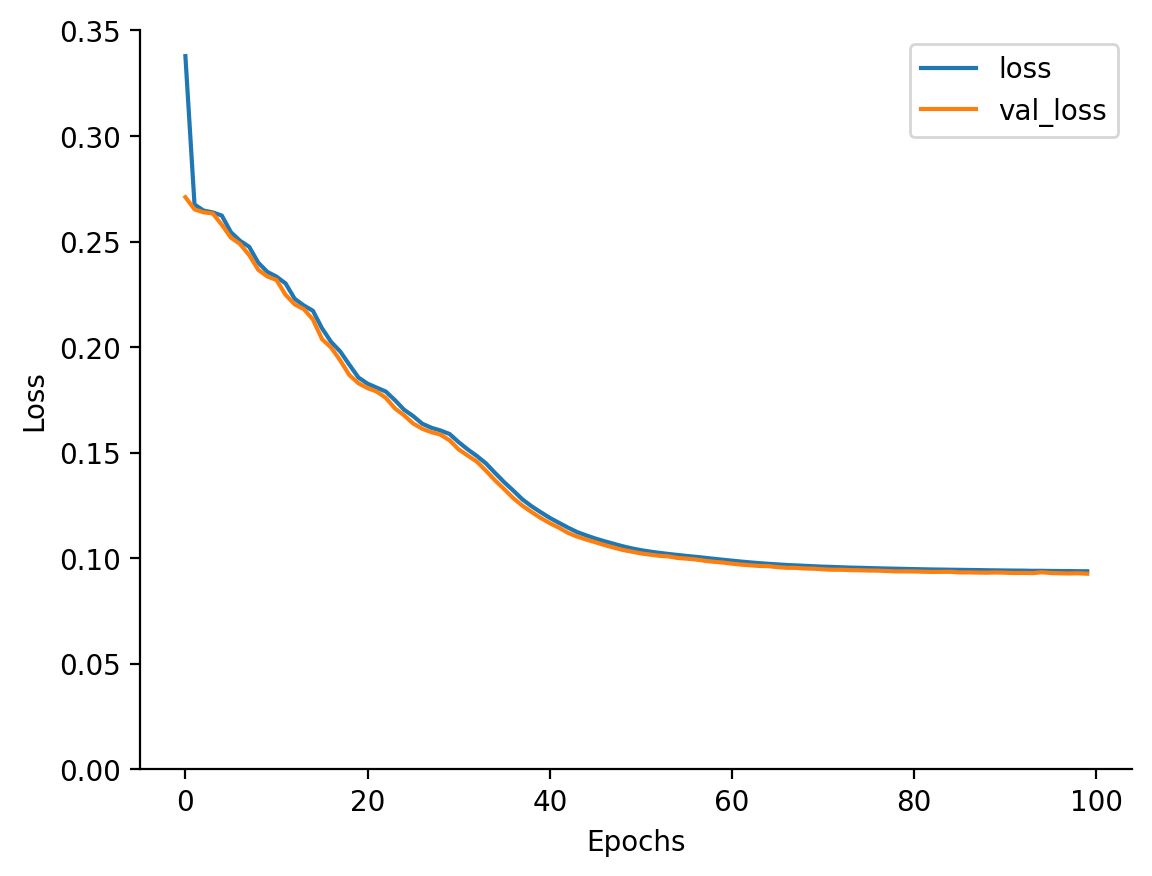

In [11]:
for k in history.keys():
    plt.plot(history[k], label=k)
plt.legend()
plt.ylim(0, None)
plt.xlabel('Epochs')
plt.ylabel('Loss')
sns.despine()

Save the models.

In [12]:
autoencoder.save('../data/autoencoder.keras')
encoder.save('../data/encoder.keras')
decoder.save('../data/decoder.keras')

Load the models.

In [13]:
autoencoder = keras.models.load_model('../data/autoencoder.keras')
encoder = keras.models.load_model('../data/encoder.keras')
decoder = keras.models.load_model('../data/decoder.keras')

Let's see how the autoencoder performs by encoding and decoding some digits.

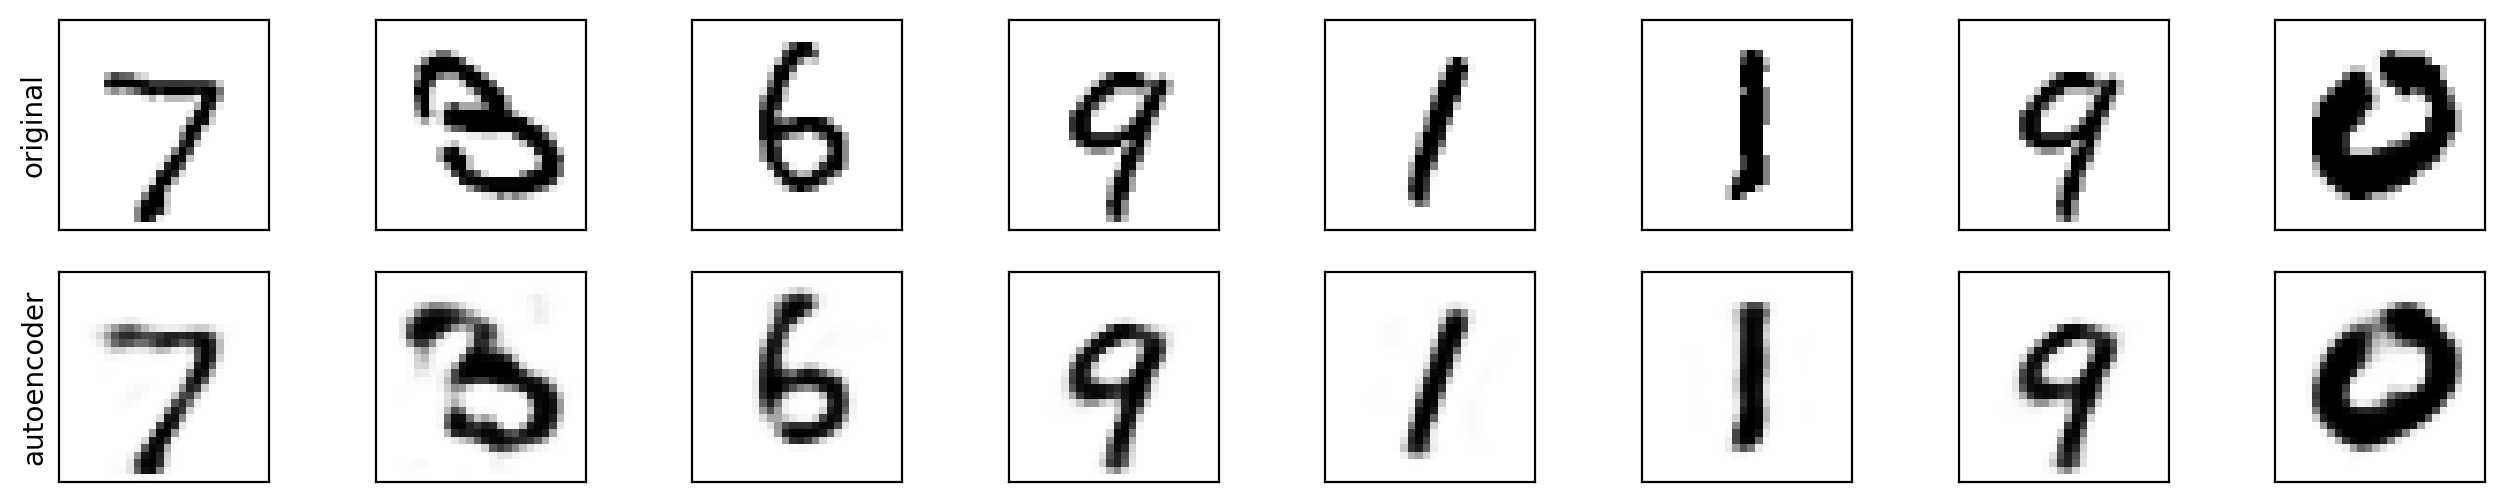

In [25]:
idx = jax.random.choice(jax.random.key(2313), X_test.shape[1], shape=(8,))
img = X_test[idx]
recon = autoencoder.predict(img, verbose=False)

fig, axes = plt.subplots(2, 8, figsize=(16, 3), sharex=True, sharey=True)
for i in range(8):
    axes[0, i].imshow(img[i], cmap='gray_r')
    axes[1, i].imshow(recon[i], cmap='gray_r')
axes[0,0].set(xticks=[], yticks=[], ylabel='original')
axes[1,0].set(ylabel='autoencoder');

# Denoising autoencoder

Autoencoders can be used for denoising.

We train the autoencoder on reconstructing the clean image from a noisy image.

Let's start by adding Gaussian noise to the images.

In [27]:
key = jax.random.key(2974)
σ = 0.5
X_train_noise = np.clip(X_train + σ * jax.random.normal(key, shape=X_train.shape), 0., 1.)
X_test_noise = np.clip(X_test + σ * jax.random.normal(key, shape=X_test.shape) , 0., 1.)

Now we fine-tune our previously trained autoencoder on denoising for just 10 epochs.

In [28]:
history = autoencoder.fit(X_train_noise, X_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_noise, X_test)).history

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4458 - val_loss: 0.2078
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1928 - val_loss: 0.1617
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1599 - val_loss: 0.1521
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1524 - val_loss: 0.1468
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1472 - val_loss: 0.1430
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1431 - val_loss: 0.1397
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1402 - val_loss: 0.1367
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1379 - val_loss: 0.1351
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1360 - val_loss: 0.1337
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1349 - val_loss: 0.1327


In [30]:
autoencoder.save('../data/denoise_autoencoder.keras')

In [31]:
autoencoder = keras.models.load_model('../data/denoise_autoencoder.keras')

Let's see how it performs in cleaning noisy images!

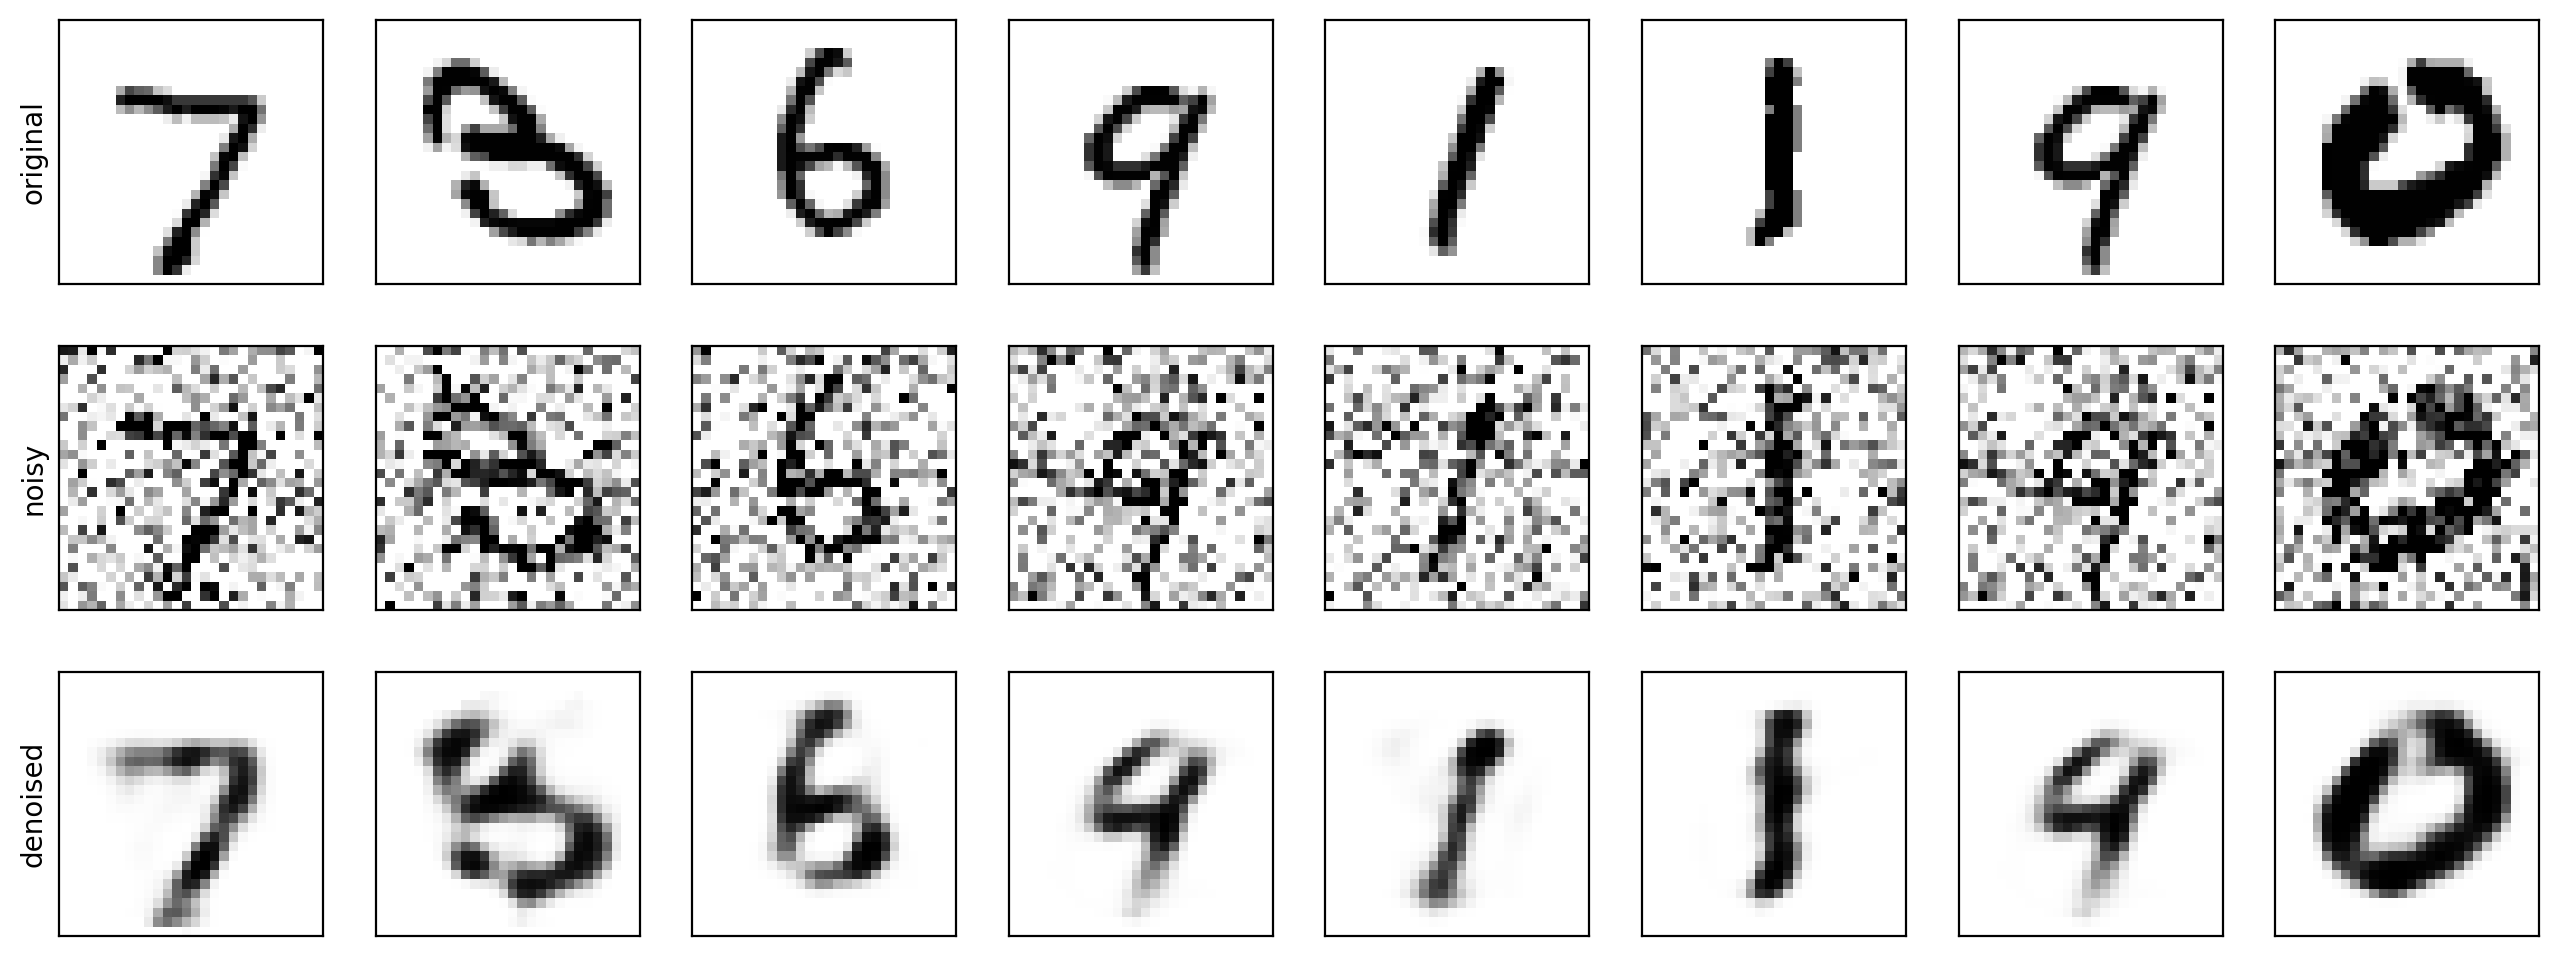

In [34]:
idx = jax.random.choice(jax.random.key(2313), X_test.shape[1], shape=(8,))
img = X_test[idx]
img_noise = X_test_noise[idx]
recon = autoencoder.predict(img_noise, verbose=False)

fig, axes = plt.subplots(3, 8, figsize=(16, 6), sharex=True, sharey=True)
for i in range(8):
    axes[0, i].imshow(img[i], cmap='gray_r')
    axes[1, i].imshow(img_noise[i], cmap='gray_r')
    axes[2, i].imshow(recon[i], cmap='gray_r')
axes[0,0].set(xticks=[], yticks=[], ylabel='original')
axes[1,0].set(ylabel='noisy')
axes[2,0].set(ylabel='denoised');

# References

- Keras autoencoders [examples](https://blog.keras.io/building-autoencoders-in-keras.html).

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)